In [40]:
%load_ext autoreload

In [41]:
%autoreload 2

# A beginner's guide to develop and deploy a modern data pipeline to production infrastructure

## Inroduction
Using two tasks this guide will go through the three principle devolpments stages necessary to develop a modern data pipeline in python.  

Our motivating example is a toy ETL pipeline that extracs data from the Toronto Stock Exchange's Market on Close facilty website and loads into a database.  The data is published every trading day at 15:40 Toronto time and at midnight the table gets flushed out.

#### Pipeline tasks
1. Extract MOC imbalance data from the TSX website
2. Load the data into a `postgress` database

Even with this simple pipeline various exceptions need to be handled .e.g. api changes, connection errors. In this pipeline the data is only available for a limited time.  As such saving intermediate results is crucial.  It would be a shame to lose a day's results because of a bad write to the database.

In reality a pipeline will include other tasks that might: (1) Extract data from many sources at different time zones. (2) Prepare the data for analytics or prediction algorithm(s). (3) run multiple statistical experiments on decentralized infrastructure.


#### Principle stages and tools
1.  Write the base code
2.  Implement task configuration and orchestration logic for individual tasks and the pipeline. i.e. error handling, execution logic
3.  Deploy the flow to a compute enviroment. Local, self hosted or IaaS providor. In our case AWS

| Development Stage | Tool | Purpose | pip install |
|------|------|------|------|
|  Base code  | `requests`, `lxml`, `html5lib`| extract content from web | pip install requests lxml html5lib|
| | pandas| transforming and passing data | pip install requests pandas |
| | datetime | Handling dates | pip install datetime |
| | psycopg2 | database driver | psycopg2 |
|  Task configuration and orchestration  | prefect| orchestration, configuration, execution method | pip install -U "prefect[viz, aws]" |
|  Deployment  | prefect| Scheduling and monitoring |  |
| | AWS Batch | compute | Instructions in guide |
| | AWS ECR | docker repo | Instructions in guide |
| | AWS s3| object storage | - |

#### Requirements
- An AWS account
    - aws cli configured on the lcoal machine. [Instructions](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html)
- postgres db - Remote lazy way: [Lightsail](https://aws.amazon.com/lightsail/) is free for a month, easy to setup and teardown for experiments. postgress or mysql.
- Docker - [docker install](https://docs.docker.com/engine/install/#supported-platforms).  
- graphviz - [download](https://www.graphviz.org/download/).  Choose your os.
- python 3.7
    - prefect - `pip install -U "prefect[viz, aws]"` See [prefect install](https://docs.prefect.io/core/getting_started/installation.html) for other possibilities.
    

## Base pipeline tasks
Context - Our base code will live in a directory called `prefect_guide`. In one file called `get_moc.py`.  Both can be named any valid unix valid names.

### a. Extract MOC imbalance data from the TSX website

The first task is to retrieve data from a table from the [TSX website](https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html)  using `requests`.  The task returns and returns a `dataframe` with the MOC imbalances for the day. 

In [6]:
import pandas as pd
import requests


import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

def get_tsx_moc_imb(url: str):
    """
    Scrape the TSX website Market on close website. Data only available weekdays after 15:40 pm Toronto time
    until 12 am.
    
    Use archived url for testing.       
    "https://web.archive.org/web/20200414202757/https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html"
    """
    
    # 1, Get the html content
    html = requests.get(url).content
    
    # 2. Read all the tables
    df_list = pd.read_html(html, header=[0], na_values=[''], keep_default_na=False)
    
    tsx_imb_df = df_list[-1]
    
    logger.info(f"MOC download shape {tsx_imb_df.shape}")

    return tsx_imb_df

#### Run the function

After running the function below the user will get one of three results: 

   1. A dataframe having a shape of `[num_rows > 1, 4]`
   2. A dataframe having a shape of `[0, 4]`
   3. Some connection error .i.e. `RemoteDisconnected`, ... 

No matter what result is returned, it will be handled later in the configuration and orchastration stage. But for the purposes of validating the next step use the `backup_url` given below 

In [43]:
tsx_url = 'https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html'
backup_url = "https://web.archive.org/web/20200414202757/https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html"

tsx_imb_df = get_tsx_moc_imb(backup_url)
print(tsx_imb_df.shape)
tsx_imb_df.head(3)  

(389, 4)


,Symbol,Imbalance Side,Imbalance Size,Imbalance Reference Price
0,AAV,BUY,34003,1.725
1,ABX,BUY,460592,34.005
2,ACB,BUY,211790,1.035


### b. Load to database

This task takes the transformed data as an input and loads the `imb_df` to a database using `sqlAlchemy`.  There are many ways to accomplish this goal, including some baked into `prefect`. But this is the simplest in terms of writing from a small `df`. 

In [55]:
import sqlalchemy as sa
def df_to_db(df, tbl_name, conn_str):

    engine = sa.create_engine(conn_str)
    
    df.to_sql(
        name=tbl_name,
        con=engine,
        if_exists="append",
        index=True,
        method="multi",
        chunksize=5000
        )
    
    engine.dispose()
  
    return df.shape

Build a connection string using your own credentials for the db

In [56]:
usr_nm = 'something'
pwd = "verysecret"
host = "some_endpoint or ip"
db_nm = "tst"

db_string = f"postgres://{usr_nm}:{pwd}@{host}/{db_nm}"

Run the function.  A new table with the imb data should now be inserted

In [57]:
df_shape = df_to_db(imb_df, tbl_name="moc_tst", conn_str=s.get())
df_shape

(389, 4)

## Stage 2 - Configuration and Orchestration for production

Next we set up the `prefect` config to set:.  
- `checkpointing` to True when a `Result handler` is given as a keyword argument. 
- `cloud.secrets` to True  this way the secrets stored  on prefect cloud to be called
    - Secrets can also be used locally with enviroment variables see link

Setting up the prefect config for deployment: 

1. In the terminal go to the prefect directory

    cd ~
    
    cd .prefect
2. Check if a config exists

    ls

    

    If it does not exist:
    
    touch config.toml

3. Open the file.

    nano config.toml

4. Get a cloud token from prefect

5. Add the following configuration.  [prefect config](https://docs.prefect.io/core/concepts/configuration.html)
  
 
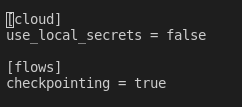

6. quit nano

### Configuring the `get_tsx_moc_imb` to handle retries and saving its result to `s3`.

In the code below an @task decorator was added with four configurations to handle some possiple errors.  Furthermore the LocalResultHandler, S3ResultHandler were importedto write the tasks results to a location specified.  If a directory is not specified in the localhandler, the result is located in ~.prefect/results

for all the possible keyword configurations see [`Tasks`](https://docs.prefect.io/api/latest/core/task.html#task-2)

In addition a state handler was added to handle the state of our `task` .  The state handler handles the definition of the state Success, In progress, pending Failure.  This is where the empty dataframe is handled.  There is no reason to for the `write to db` task to attempt running if there is an empty dataframe. 

In [10]:
import pandas as pd
import requests

from datetime import timedelta

from prefect import task
from prefect.engine.result_handlers import LocalResultHandler, S3ResultHandler

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

s3_handler = S3ResultHandler(bucket='tsx-moc-bcp')  
lcl_handler = LocalResultHandler()

def my_state_handler(obj, old_state, new_state):
    msg = "\nCalling my custom state handler on {0}:\n{1} to {2}\n"
    print(msg.format(obj, old_state, new_state))
    return new_state

@task(
    max_retries=2, 
    retry_delay=timedelta(seconds=1),
    result_handler=s3_handler)
    #state_handlers=[])
def get_tsx_moc_imb(url: str):
    """
    Scrape the TSX website Market on close website. Data only available weekdays after 15:40 pm Toronto time
    until 12 am.
    
    Use archived url for testing.       
    "https://web.archive.org/web/20200414202757/https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html"
    """
    # assert 1/0
    
    # 1, Get the html content
    html = requests.get(url).content
    
    # 2. Read all the tables
    df_list = pd.read_html(html, header=[0], na_values=[''], keep_default_na=False)
    
    tsx_imb_df = df_list[-1]
    
    logger.info(f"MOC download shape {tsx_imb_df.shape}")

    return tsx_imb_df

The task above can still be developed and run using the `run` method, however none of the configurations that were added will take hold.

In [11]:
tsx_url = 'https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html'
backup_url = "https://web.archive.org/web/20200414202757/https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html"

tsx_imb_df = get_tsx_moc_imb.run(tsx_url)
tsx_imb_df

,Symbol,Imbalance Side,Imbalance Size,Imbalance Reference Price


As previoulsy discussed configuration and orchestration go together. With `prefect` orchestration takes place in a `Flow`.  A `Flow` has it's own configurations: [Executor](https://docs.prefect.io/api/latest/engine/executors.html#executors), result handler ect.  The code below explicitely defines them so we can change the configurations as we move towards production.

Flows can be written in one of three ways: (1) [The functional api](https://docs.prefect.io/core/getting_started/first-steps.html#functional-api) (2) [Imperative api](https://docs.prefect.io/core/getting_started/first-steps.html#imperative-api) (3) Or a combination of both.  

This guide uses the functional api.

In [17]:
from prefect import Flow, Parameter

with Flow("Get-TSX-MOC-Imbalances") as tsx_imb_fl:
    
    tsx_url = Parameter("tsx_url", default="https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html")
    
    tsx_imb_df = get_tsx_moc_imb(tsx_url)
    

The flow can be visualized without running it. 

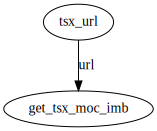

In [19]:
tsx_imb_fl.visualize()

This is useful to understand a Flow's logic and perhaps optimize it.

### Running the flow

Run the flow locally using a Local Executor and visualize how tasks are connected.  
As the flow is running you will see messages displaying the status of the `flow`

[2020-04-30 19:08:51] INFO - prefect.FlowRunner | Beginning Flow run for 'Get-TSX-MOC-Imbalances'
[2020-04-30 19:08:51] INFO - prefect.FlowRunner | Starting flow run.
[2020-04-30 19:08:51] INFO - prefect.TaskRunner | Task 'tsx_url': Starting task run...
[2020-04-30 19:08:51] INFO - prefect.TaskRunner | Task 'tsx_url': finished task run for task with final state: 'Success'
[2020-04-30 19:08:51] INFO - prefect.TaskRunner | Task 'get_tsx_moc_imb': Starting task run...
[2020-04-30 19:08:52] INFO - prefect.TaskRunner | Task 'get_tsx_moc_imb': finished task run for task with final state: 'Success'
[2020-04-30 19:08:52] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


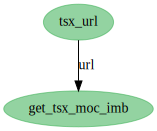

In [26]:
from prefect.engine.executors import LocalExecutor

#from prefect.environments import RemoteEnvironment
#tsx_imb_fl.environment=RemoteEnvironment(executor="prefect.engine.executors.LocalExecutor")

fl_state = tsx_imb_fl.run(
    parameters=dict(
        tsx_url="https://api.tmxmoney.com/mocimbalance/en/TSX/moc.html"
    ), 
    executor=LocalExecutor()
)
tsx_imb_fl.visualize(flow_state=fl_state)

#### Logging

The flow began succesfully

`[2020-04-30 17:38:57] INFO - prefect.FlowRunner | Beginning Flow run for "Get TSX MOC imbalances"`

The `tsx_url` Parameter was initialized succefuly

`[2020-04-30 17:38:57] INFO - prefect.TaskRunner | Task 'tsx_url': Starting task run...
[2020-04-30 17:38:57] INFO - prefect.TaskRunner | Task 'tsx_url': finished task run for task with final state: 'Success'`

The `get_tsx_moc_imb` enterd and succesfully finished

`[2020-04-30 17:38:57] INFO - prefect.TaskRunner | Task 'tsx_url': Starting task run...
[2020-04-30 17:38:57] INFO - prefect.TaskRunner | Task 'tsx_url': finished task run for task with final state: 'Success'`

#### Executor

`prefect` has three executors built in.

    - Local executor. for dev
    - LocalDaskExecutor. for dev. No parrallism
    - DaskExecutor. for production
    

The results can be accesses using


In [27]:
print(fl_state.result[tsx_imb_df].result)
print(fl_state.result[tsx_imb_df]._result.safe_value)

Empty DataFrame
Columns: [Symbol, Imbalance Side, Imbalance Size, Imbalance Reference Price]
Index: []
<SafeResult: '2020/4/30/83bb8f9a-88d6-4f0b-87d9-a6a612c9d7e5.prefect_result'>
